In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

how do EPD and CAHOOTS arrival times vary by call priority, by time of day, by day of week, and by call type

### POSSIBLE TODO's
Change how CAHOOT column id formated, dont want true false want them labeled as CAHOOT and Other

Graph/compare wheter dispatch, arrival and clear times have some sort of effect or correlation with each other

Check if call volume of CAHOOTS calls varies with response times

# Cleaning

## Loading
Loading in and looking at dataframe

In [6]:
call_data = pd.read_csv("class_data_14-25.csv", dtype={"zip": str, "case_id": str})

In [7]:
call_data.head()

,yr,service,inci_id,calltime,case_id,callsource,nature,closecode,closed_as,secs_to_disp,secs_to_arrv,secs_to_close,disp,arrv,beat,priority,zip,primeunit,units_dispd,units_arrived
0,2014,LAW,14000001,2014-01-01 00:00:05.000,NaN,SELF,TRAFFIC STOP,UTC,UNIFORM TRAFFIC CITATION ISSUED,1.0,1.0,690,1,1,EP05,6,97402,5Z51,1,1
1,2014,LAW,14000003,2014-01-01 00:01:50.000,NaN,SELF,TRAFFIC STOP,ADVI,ADVISED,0.0,0.0,170,1,1,EP02,6,97401,5T82,2,2
2,2014,LAW,14000006,2014-01-01 00:05:17.000,NaN,PHONE,DISPUTE,ADVI,ADVISED,219.0,596.0,1444,1,1,EP01,3,97401,5E93,3,2
3,2014,LAW,14000007,2014-01-01 00:08:36.000,NaN,SELF,TRAFFIC STOP,WARN,WARNING,0.0,0.0,427,1,1,EP02,6,97401,5E31,2,2
4,2014,LAW,14000011,2014-01-01 00:10:21.000,NaN,E911,THEFT,RSLV,RESOLVED,168.0,380.0,1126,1,1,EP05,3,97402,6E45,2,2


## Arrival, Dispatch, and Clear Times

It looks like dispatch, arrival, and close times are all in seconds, it would be much easier to read and compare if they were in minutes

In [10]:
call_data["dispatch_time"] = call_data["secs_to_disp"]/60
call_data["arrival_time"] = call_data["secs_to_arrv"]/60
call_data["clear_time"] = call_data["secs_to_close"]/60

In [11]:
call_data.head(5)

,yr,service,inci_id,calltime,case_id,callsource,nature,closecode,closed_as,secs_to_disp,...,arrv,beat,priority,zip,primeunit,units_dispd,units_arrived,dispatch_time,arrival_time,clear_time
0,2014,LAW,14000001,2014-01-01 00:00:05.000,NaN,SELF,TRAFFIC STOP,UTC,UNIFORM TRAFFIC CITATION ISSUED,1.0,...,1,EP05,6,97402,5Z51,1,1,0.016667,0.016667,11.500000
1,2014,LAW,14000003,2014-01-01 00:01:50.000,NaN,SELF,TRAFFIC STOP,ADVI,ADVISED,0.0,...,1,EP02,6,97401,5T82,2,2,0.000000,0.000000,2.833333
2,2014,LAW,14000006,2014-01-01 00:05:17.000,NaN,PHONE,DISPUTE,ADVI,ADVISED,219.0,...,1,EP01,3,97401,5E93,3,2,3.650000,9.933333,24.066667
3,2014,LAW,14000007,2014-01-01 00:08:36.000,NaN,SELF,TRAFFIC STOP,WARN,WARNING,0.0,...,1,EP02,6,97401,5E31,2,2,0.000000,0.000000,7.116667
4,2014,LAW,14000011,2014-01-01 00:10:21.000,NaN,E911,THEFT,RSLV,RESOLVED,168.0,...,1,EP05,3,97402,6E45,2,2,2.800000,6.333333,18.766667


## Identifying CAHOOT Calls

We need to identify which calls CAHOOTS responded too.
For the old data, CAHOOTS call signs are XJXX or some form of CAHOOTS abreviated (CAH, CAHOT, CAHOOT)

In [14]:
units = []
for i in call_data["primeunit"].astype(str).unique():
    units.append(i[1])

In [15]:
pd.Series(units).unique() == "J"

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [16]:
units = []
for i in call_data["primeunit"].astype(str).unique():
    if i[0] == "C":
        units.append(i)
units

['CMD10 ',
 'CAHOOT',
 'CMD2  ',
 'CMD6  ',
 'CMD9  ',
 'CNTR  ',
 'CMD5  ',
 'CMD4  ',
 'CMD1  ',
 'CNT   ',
 'C1    ',
 'CMD8  ',
 'CMD3  ',
 'CMD03 ',
 'CMD7  ',
 'C8    ',
 'CMD12 ',
 'CMD11 ',
 'CMD16 ',
 'CMD13 ',
 'C100  ',
 'CMD14 ']

It looks like for this dataset CAHOOT units are only labeled with 'CAHOOT'. Adding a boolean column if a call was a CAHOOT response or not

In [18]:
call_data["CAHOOT"] = (call_data["primeunit"] == "CAHOOT")

## Time of Day and Day of Week

Creating new columns that contain what hour of the day and day of the week the calls were place

In [21]:
call_data["Hour"] = pd.DatetimeIndex(call_data['calltime']).hour
call_data["DoW"] = pd.DatetimeIndex(call_data['calltime']).dayofweek

In [22]:
call_data.sample(n=5)

,yr,service,inci_id,calltime,case_id,callsource,nature,closecode,closed_as,secs_to_disp,...,zip,primeunit,units_dispd,units_arrived,dispatch_time,arrival_time,clear_time,CAHOOT,Hour,DoW
413968,2017,LAW,17103061,2017-05-05 01:30:57.000,NaN,PHONE,CHECK WELFARE,ASST,ASSISTED,239.0,...,97401,CAHOOT,3,3,3.983333,12.45,141.250000,True,1,4
1031976,2021,LAW,21314898,2021-12-07 17:31:49.000,2119477,PHONE,THEFT OF LICENSE PLATE,REPT,REPORT TAKEN,NaN,...,97401,NaN,0,0,NaN,NaN,6.116667,False,17,1
68441,2014,LAW,14166651,2014-07-27 02:29:51.000,1412552.0,E911,MISSING PERSON,REPT,REPORT TAKEN,1002.0,...,97402,5E55,1,1,16.700000,27.00,151.000000,False,2,6
1343369,2024,LAW,24072919,2024-03-18 23:53:35.000,NaN,PHONE,LOUD NOISE,QOA,QUIET ON ARRIVAL,11584.0,...,97402,6E63,1,1,193.066667,NaN,193.100000,False,23,0
483812,2017,LAW,17272739,2017-11-06 12:42:44.000,NaN,PHONE,CRIMINAL TRESPASS,ADVI,ADVISED,198.0,...,97402,3E45,2,2,3.300000,7.75,32.150000,False,12,0


## Filtering Data

We are only interested in calls where a unit was dispatched, arrived on scene, and cleared the call, so if any of this information is missing we fill filter that call out of the data we are working with

Additionally it is not possible for any of these times to be negative, so filtering for only times that are possible

In [25]:
call_data.dropna(subset = ['clear_time', 'arrival_time', 'dispatch_time'], inplace=True)
call_data = call_data[(call_data["clear_time"] >= 0)&(call_data["arrival_time"] >= 0)&(call_data["dispatch_time"] >= 0)]
call_data.head()

,yr,service,inci_id,calltime,case_id,callsource,nature,closecode,closed_as,secs_to_disp,...,zip,primeunit,units_dispd,units_arrived,dispatch_time,arrival_time,clear_time,CAHOOT,Hour,DoW
0,2014,LAW,14000001,2014-01-01 00:00:05.000,NaN,SELF,TRAFFIC STOP,UTC,UNIFORM TRAFFIC CITATION ISSUED,1.0,...,97402,5Z51,1,1,0.016667,0.016667,11.500000,False,0,2
1,2014,LAW,14000003,2014-01-01 00:01:50.000,NaN,SELF,TRAFFIC STOP,ADVI,ADVISED,0.0,...,97401,5T82,2,2,0.000000,0.000000,2.833333,False,0,2
2,2014,LAW,14000006,2014-01-01 00:05:17.000,NaN,PHONE,DISPUTE,ADVI,ADVISED,219.0,...,97401,5E93,3,2,3.650000,9.933333,24.066667,False,0,2
3,2014,LAW,14000007,2014-01-01 00:08:36.000,NaN,SELF,TRAFFIC STOP,WARN,WARNING,0.0,...,97401,5E31,2,2,0.000000,0.000000,7.116667,False,0,2
4,2014,LAW,14000011,2014-01-01 00:10:21.000,NaN,E911,THEFT,RSLV,RESOLVED,168.0,...,97402,6E45,2,2,2.800000,6.333333,18.766667,False,0,2


# Analysis

### Methods

In [28]:
CAHOOT = call_data[call_data["CAHOOT"] == True]
t = CAHOOT["nature"].value_counts()
natures = t[t>1000]
natures.index

Index(['ASSIST PUBLIC- POLICE', 'CHECK WELFARE', 'TRANSPORT',
       'PUBLIC ASSIST, CAHOOTS', 'CHECK WELFARE, CAHOOTS', 'SUICIDAL SUBJECT',
       'SUICIDAL SUBJECT, CAHOOTS', 'TRANSPORT, CAHOOTS',
       'INTOXICATED SUBJECT', 'ASSIST PD, CAHOOTS', 'DISORDERLY SUBJECT',
       'FOUND SYRINGE', 'TRAFFIC HAZARD', 'ASSIST FIRE DEPARTMENT'],
      dtype='object', name='nature')

In [29]:
#call_data = call_data[call_data["callsource"] != "SELF"]

In [30]:
def ttest(column, value, time_type,df = call_data):
    cahoot = df[(df["CAHOOT"] == True) & (df[column] == value)][time_type]
    epd = df[(df["CAHOOT"] == False) & (df[column] == value)][time_type]
    ttest_r = stats.ttest_ind(cahoot,epd)
    print(f"CAHOOT average {time_type} for {column} of {value} is: {round(np.mean(cahoot), 3)} min for {len(cahoot)} calls")
    print(f"EPD average {time_type} for {column} of {value} is: {round(np.mean(epd), 3)} min for {len(epd)} calls")
    print(f"Two sample t-test, t-stat: {round(ttest_r[0], 3)}, p-value: {round(ttest_r[1],5)}")
    return

In [31]:
ttest("Hour",10,"arrival_time")

CAHOOT average arrival_time for Hour of 10 is: 103.493 min for 6707 calls
EPD average arrival_time for Hour of 10 is: 46.885 min for 42871 calls
Two sample t-test, t-stat: 30.401, p-value: 0.0


### Arrival Times

Text(0.5, 1.0, 'CAHOOT and Non-CAHOOT Unit Arrival Times by Hour')

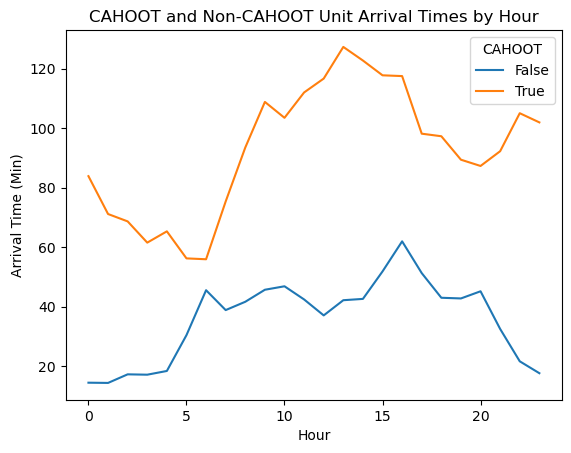

In [33]:
sns.lineplot(call_data, x = "Hour", y = "arrival_time", hue = "CAHOOT",errorbar=None)
plt.xlabel("Hour")
plt.ylabel("Arrival Time (Min)")
plt.title("CAHOOT and Non-CAHOOT Unit Arrival Times by Hour")

In [34]:
for i in range(24):
    ttest("Hour",i,"arrival_time")

CAHOOT average arrival_time for Hour of 0 is: 83.889 min for 4612 calls
EPD average arrival_time for Hour of 0 is: 14.49 min for 35468 calls
Two sample t-test, t-stat: 74.506, p-value: 0.0
CAHOOT average arrival_time for Hour of 1 is: 71.167 min for 4064 calls
EPD average arrival_time for Hour of 1 is: 14.414 min for 29671 calls
Two sample t-test, t-stat: 57.932, p-value: 0.0
CAHOOT average arrival_time for Hour of 2 is: 68.689 min for 3339 calls
EPD average arrival_time for Hour of 2 is: 17.299 min for 22595 calls
Two sample t-test, t-stat: 40.828, p-value: 0.0
CAHOOT average arrival_time for Hour of 3 is: 61.553 min for 2510 calls
EPD average arrival_time for Hour of 3 is: 17.18 min for 16382 calls
Two sample t-test, t-stat: 34.635, p-value: 0.0
CAHOOT average arrival_time for Hour of 4 is: 65.346 min for 2216 calls
EPD average arrival_time for Hour of 4 is: 18.432 min for 13970 calls
Two sample t-test, t-stat: 30.613, p-value: 0.0
CAHOOT average arrival_time for Hour of 5 is: 56.261

In [35]:
df_sorted = call_data
df_sorted = df_sorted.sort_values('DoW')

In [36]:
df_sorted['DoW'] = df_sorted['DoW'].replace(0, 'Mon')
df_sorted['DoW'] = df_sorted['DoW'].replace(1, 'Tues')
df_sorted['DoW'] = df_sorted['DoW'].replace(2, 'Wed')
df_sorted['DoW'] = df_sorted['DoW'].replace(3, 'Thurs')
df_sorted['DoW'] = df_sorted['DoW'].replace(4, 'Fri')
df_sorted['DoW'] = df_sorted['DoW'].replace(5, 'Sat')
df_sorted['DoW'] = df_sorted['DoW'].replace(6, 'Sun')

Text(0.5, 1.0, 'CAHOOT and Non-CAHOOT Unit Arrival Times by Day of The Week')

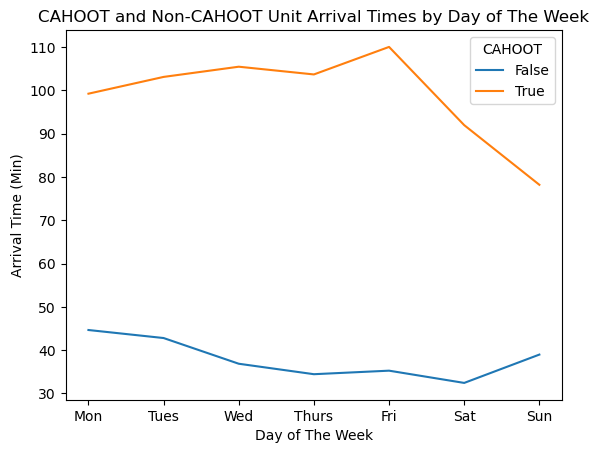

In [37]:
DoW_order = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
sns.lineplot(df_sorted, x = "DoW", y = "arrival_time", hue = "CAHOOT",errorbar=None) #, order = DoW_order
plt.xlabel("Day of The Week")
plt.ylabel("Arrival Time (Min)")
plt.title("CAHOOT and Non-CAHOOT Unit Arrival Times by Day of The Week")

In [38]:
for i in range(7):
    ttest("DoW",i,"arrival_time")

CAHOOT average arrival_time for DoW of 0 is: 99.242 min for 20701 calls
EPD average arrival_time for DoW of 0 is: 44.641 min for 105239 calls
Two sample t-test, t-stat: 52.672, p-value: 0.0
CAHOOT average arrival_time for DoW of 1 is: 103.118 min for 20079 calls
EPD average arrival_time for DoW of 1 is: 42.787 min for 114771 calls
Two sample t-test, t-stat: 58.154, p-value: 0.0
CAHOOT average arrival_time for DoW of 2 is: 105.474 min for 19963 calls
EPD average arrival_time for DoW of 2 is: 36.849 min for 124686 calls
Two sample t-test, t-stat: 72.219, p-value: 0.0
CAHOOT average arrival_time for DoW of 3 is: 103.689 min for 20007 calls
EPD average arrival_time for DoW of 3 is: 34.431 min for 130274 calls
Two sample t-test, t-stat: 79.948, p-value: 0.0
CAHOOT average arrival_time for DoW of 4 is: 110.047 min for 19860 calls
EPD average arrival_time for DoW of 4 is: 35.248 min for 130712 calls
Two sample t-test, t-stat: 82.43, p-value: 0.0
CAHOOT average arrival_time for DoW of 5 is: 91

Text(0.5, 1.0, 'CAHOOT and Non-CAHOOT Unit Arrival Times by Call Priority')

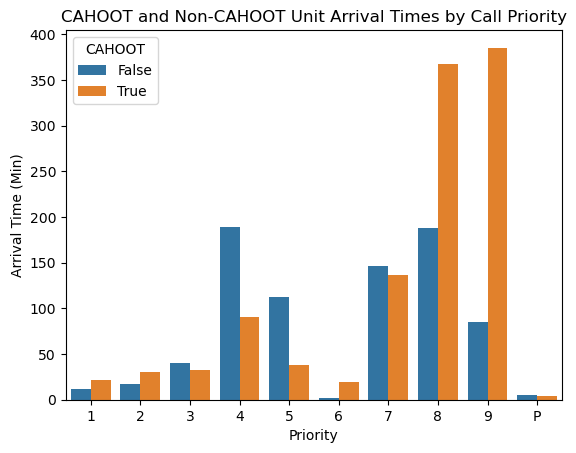

In [39]:
orders =  ["1", "2", "3", "4", "5", "6", "7", "8", "9", "P"]
sns.barplot(call_data, x = "priority", y = "arrival_time", hue = "CAHOOT", order = orders, errorbar = None)
plt.xlabel("Priority")
plt.ylabel("Arrival Time (Min)")
plt.title("CAHOOT and Non-CAHOOT Unit Arrival Times by Call Priority")

In [40]:
for i in orders:
    ttest("priority",i,"arrival_time")

CAHOOT average arrival_time for priority of 1 is: 21.361 min for 3985 calls
EPD average arrival_time for priority of 1 is: 11.747 min for 36397 calls
Two sample t-test, t-stat: 26.1, p-value: 0.0
CAHOOT average arrival_time for priority of 2 is: 30.736 min for 28 calls
EPD average arrival_time for priority of 2 is: 17.413 min for 3899 calls
Two sample t-test, t-stat: 1.786, p-value: 0.07413
CAHOOT average arrival_time for priority of 3 is: 32.816 min for 11328 calls
EPD average arrival_time for priority of 3 is: 40.396 min for 276704 calls
Two sample t-test, t-stat: -10.795, p-value: 0.0
CAHOOT average arrival_time for priority of 4 is: 90.318 min for 183 calls
EPD average arrival_time for priority of 4 is: 188.796 min for 55580 calls
Two sample t-test, t-stat: -5.341, p-value: 0.0
CAHOOT average arrival_time for priority of 5 is: 37.725 min for 34261 calls
EPD average arrival_time for priority of 5 is: 111.951 min for 58884 calls
Two sample t-test, t-stat: -61.09, p-value: 0.0
CAHOOT 

In [41]:
nats = call_data[call_data["nature"].isin(['ASSIST PUBLIC- POLICE', 'CHECK WELFARE', 'TRANSPORT',
       'PUBLIC ASSIST, CAHOOTS', 'CHECK WELFARE, CAHOOTS', 'SUICIDAL SUBJECT',
       'SUICIDAL SUBJECT, CAHOOTS', 'TRANSPORT, CAHOOTS',
       'INTOXICATED SUBJECT', 'ASSIST PD, CAHOOTS', 'DISORDERLY SUBJECT',
       'FOUND SYRINGE', 'TRAFFIC HAZARD', 'ASSIST FIRE DEPARTMENT'])]

Text(0.5, 1.0, 'CAHOOT and Non-CAHOOT Unit Arrival Times by Call Nature')

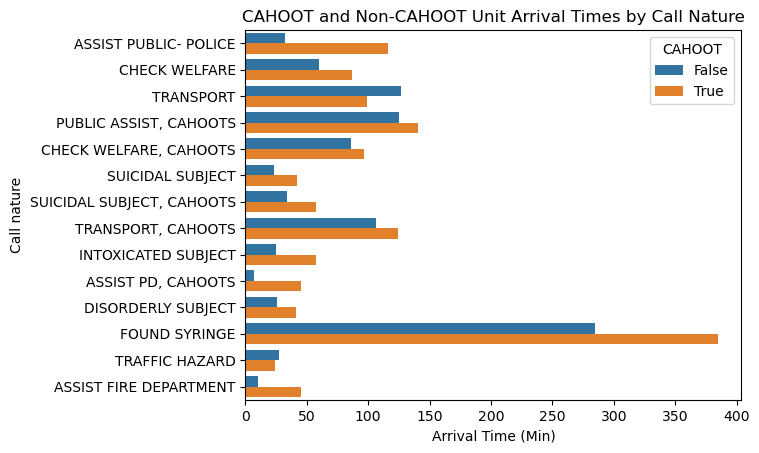

In [42]:
nat_order = ['ASSIST PUBLIC- POLICE', 'CHECK WELFARE', 'TRANSPORT',
       'PUBLIC ASSIST, CAHOOTS', 'CHECK WELFARE, CAHOOTS', 'SUICIDAL SUBJECT',
       'SUICIDAL SUBJECT, CAHOOTS', 'TRANSPORT, CAHOOTS',
       'INTOXICATED SUBJECT', 'ASSIST PD, CAHOOTS', 'DISORDERLY SUBJECT',
       'FOUND SYRINGE', 'TRAFFIC HAZARD', 'ASSIST FIRE DEPARTMENT']
sns.barplot(nats, y = "nature", x = "arrival_time", hue = "CAHOOT", order = nat_order, errorbar = None)
plt.ylabel("Call nature")
plt.xlabel("Arrival Time (Min)")
plt.title("CAHOOT and Non-CAHOOT Unit Arrival Times by Call Nature")

In [43]:
for i in nat_order:
    ttest("nature",i,"arrival_time", df = nats)

CAHOOT average arrival_time for nature of ASSIST PUBLIC- POLICE is: 116.121 min for 32612 calls
EPD average arrival_time for nature of ASSIST PUBLIC- POLICE is: 32.31 min for 5487 calls
Two sample t-test, t-stat: 41.495, p-value: 0.0
CAHOOT average arrival_time for nature of CHECK WELFARE is: 86.415 min for 30254 calls
EPD average arrival_time for nature of CHECK WELFARE is: 59.925 min for 29390 calls
Two sample t-test, t-stat: 27.397, p-value: 0.0
CAHOOT average arrival_time for nature of TRANSPORT is: 99.395 min for 21355 calls
EPD average arrival_time for nature of TRANSPORT is: 127.025 min for 1030 calls
Two sample t-test, t-stat: -7.31, p-value: 0.0
CAHOOT average arrival_time for nature of PUBLIC ASSIST, CAHOOTS is: 140.432 min for 13459 calls
EPD average arrival_time for nature of PUBLIC ASSIST, CAHOOTS is: 124.74 min for 10 calls
Two sample t-test, t-stat: 0.294, p-value: 0.76901
CAHOOT average arrival_time for nature of CHECK WELFARE, CAHOOTS is: 96.352 min for 11444 calls
EPD

Cahoots appears to be slower in most cases than EPD but it could be because Cahoots does not have access to sirens

### Clear Times

Text(0.5, 1.0, 'CAHOOT and Non-CAHOOT Unit Clear Times by Hour')

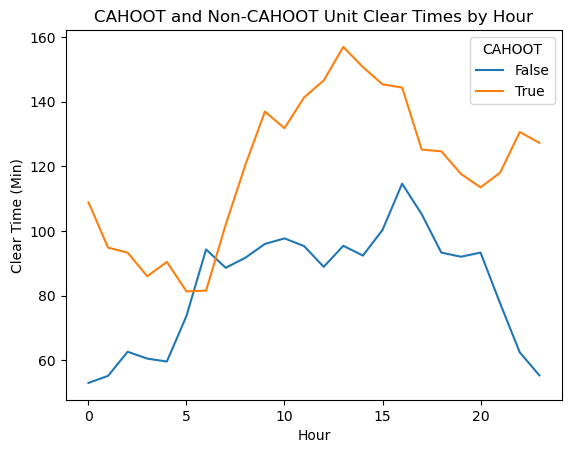

In [46]:
sns.lineplot(call_data, x = "Hour", y = "clear_time", hue = "CAHOOT",errorbar=None)
plt.xlabel("Hour")
plt.ylabel("Clear Time (Min)")
plt.title("CAHOOT and Non-CAHOOT Unit Clear Times by Hour")

In [47]:
for i in range(24):
    ttest("Hour",i,"clear_time")

CAHOOT average clear_time for Hour of 0 is: 108.882 min for 4612 calls
EPD average clear_time for Hour of 0 is: 52.951 min for 35468 calls
Two sample t-test, t-stat: 36.942, p-value: 0.0
CAHOOT average clear_time for Hour of 1 is: 94.836 min for 4064 calls
EPD average clear_time for Hour of 1 is: 55.132 min for 29671 calls
Two sample t-test, t-stat: 22.746, p-value: 0.0
CAHOOT average clear_time for Hour of 2 is: 93.287 min for 3339 calls
EPD average clear_time for Hour of 2 is: 62.598 min for 22595 calls
Two sample t-test, t-stat: 15.059, p-value: 0.0
CAHOOT average clear_time for Hour of 3 is: 85.954 min for 2510 calls
EPD average clear_time for Hour of 3 is: 60.479 min for 16382 calls
Two sample t-test, t-stat: 11.959, p-value: 0.0
CAHOOT average clear_time for Hour of 4 is: 90.42 min for 2216 calls
EPD average clear_time for Hour of 4 is: 59.57 min for 13970 calls
Two sample t-test, t-stat: 7.668, p-value: 0.0
CAHOOT average clear_time for Hour of 5 is: 81.288 min for 2637 calls
EP

Text(0.5, 1.0, 'CAHOOT and Non-CAHOOT Unit Clear Times by Day of The Week')

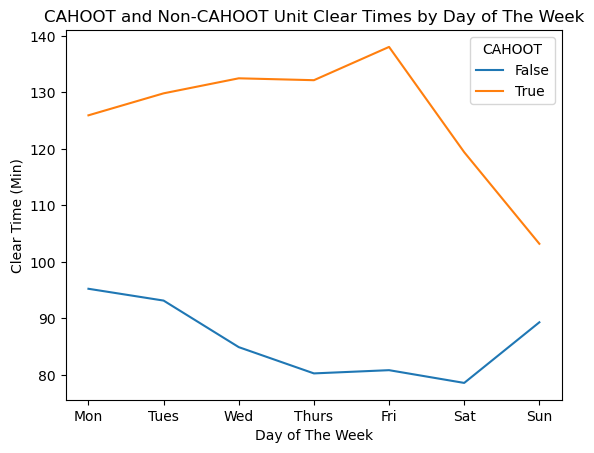

In [48]:
sns.lineplot(df_sorted, x = "DoW", y = "clear_time", hue = "CAHOOT",errorbar=None) #, order = DoW_order
plt.xlabel("Day of The Week")
plt.ylabel("Clear Time (Min)")
plt.title("CAHOOT and Non-CAHOOT Unit Clear Times by Day of The Week")

In [49]:
for i in range(7):
    ttest("DoW",i,"clear_time")

CAHOOT average clear_time for DoW of 0 is: 125.958 min for 20701 calls
EPD average clear_time for DoW of 0 is: 95.253 min for 105239 calls
Two sample t-test, t-stat: 24.204, p-value: 0.0
CAHOOT average clear_time for DoW of 1 is: 129.852 min for 20079 calls
EPD average clear_time for DoW of 1 is: 93.163 min for 114771 calls
Two sample t-test, t-stat: 26.508, p-value: 0.0
CAHOOT average clear_time for DoW of 2 is: 132.512 min for 19963 calls
EPD average clear_time for DoW of 2 is: 84.921 min for 124686 calls
Two sample t-test, t-stat: 39.21, p-value: 0.0
CAHOOT average clear_time for DoW of 3 is: 132.177 min for 20007 calls
EPD average clear_time for DoW of 3 is: 80.272 min for 130274 calls
Two sample t-test, t-stat: 46.721, p-value: 0.0
CAHOOT average clear_time for DoW of 4 is: 138.068 min for 19860 calls
EPD average clear_time for DoW of 4 is: 80.843 min for 130712 calls
Two sample t-test, t-stat: 49.821, p-value: 0.0
CAHOOT average clear_time for DoW of 5 is: 119.431 min for 20046 c

Text(0.5, 1.0, 'CAHOOT and Non-CAHOOT Unit Clear Times by Call Priority')

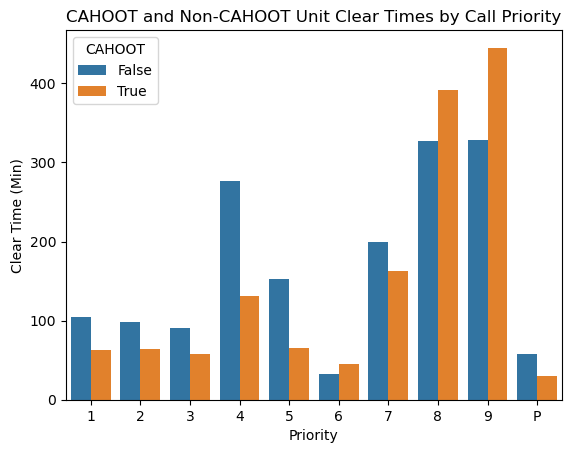

In [50]:
orders =  ["1", "2", "3", "4", "5", "6", "7", "8", "9", "P"]
sns.barplot(call_data, x = "priority", y = "clear_time", hue = "CAHOOT", order = orders, errorbar = None)
plt.xlabel("Priority")
plt.ylabel("Clear Time (Min)")
plt.title("CAHOOT and Non-CAHOOT Unit Clear Times by Call Priority")

In [51]:
for i in orders:
    ttest("priority",i,"clear_time")

CAHOOT average clear_time for priority of 1 is: 62.603 min for 3985 calls
EPD average clear_time for priority of 1 is: 104.898 min for 36397 calls
Two sample t-test, t-stat: -14.597, p-value: 0.0
CAHOOT average clear_time for priority of 2 is: 63.924 min for 28 calls
EPD average clear_time for priority of 2 is: 97.902 min for 3899 calls
Two sample t-test, t-stat: -1.493, p-value: 0.13557
CAHOOT average clear_time for priority of 3 is: 57.803 min for 11328 calls
EPD average clear_time for priority of 3 is: 91.154 min for 276704 calls
Two sample t-test, t-stat: -31.606, p-value: 0.0
CAHOOT average clear_time for priority of 4 is: 131.353 min for 183 calls
EPD average clear_time for priority of 4 is: 277.102 min for 55580 calls
Two sample t-test, t-stat: -7.266, p-value: 0.0
CAHOOT average clear_time for priority of 5 is: 65.412 min for 34261 calls
EPD average clear_time for priority of 5 is: 152.582 min for 58884 calls
Two sample t-test, t-stat: -60.188, p-value: 0.0
CAHOOT average clear

Text(0.5, 1.0, 'CAHOOT and Non-CAHOOT Unit Clear Times by Call Nature')

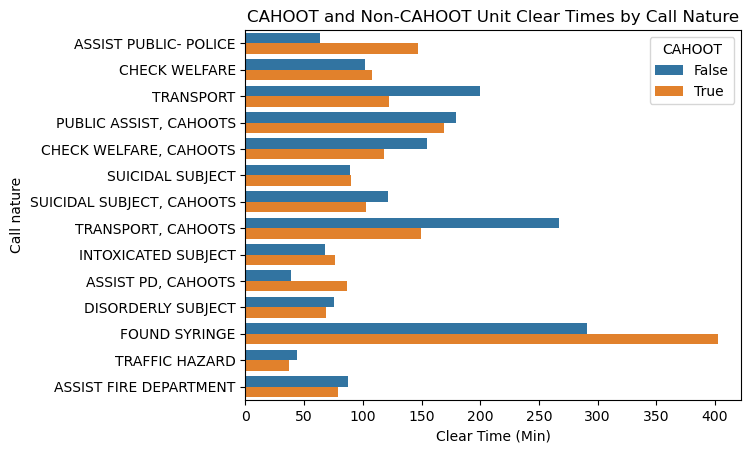

In [52]:
nat_order = ['ASSIST PUBLIC- POLICE', 'CHECK WELFARE', 'TRANSPORT',
       'PUBLIC ASSIST, CAHOOTS', 'CHECK WELFARE, CAHOOTS', 'SUICIDAL SUBJECT',
       'SUICIDAL SUBJECT, CAHOOTS', 'TRANSPORT, CAHOOTS',
       'INTOXICATED SUBJECT', 'ASSIST PD, CAHOOTS', 'DISORDERLY SUBJECT',
       'FOUND SYRINGE', 'TRAFFIC HAZARD', 'ASSIST FIRE DEPARTMENT']
sns.barplot(nats, y = "nature", x = "clear_time", hue = "CAHOOT", order = nat_order, errorbar = None)
plt.ylabel("Call nature")
plt.xlabel("Clear Time (Min)")
plt.title("CAHOOT and Non-CAHOOT Unit Clear Times by Call Nature")

In [53]:
for i in nat_order:
    ttest("nature",i,"clear_time", df = nats)

CAHOOT average clear_time for nature of ASSIST PUBLIC- POLICE is: 147.068 min for 32612 calls
EPD average clear_time for nature of ASSIST PUBLIC- POLICE is: 63.607 min for 5487 calls
Two sample t-test, t-stat: 39.825, p-value: 0.0
CAHOOT average clear_time for nature of CHECK WELFARE is: 107.957 min for 30254 calls
EPD average clear_time for nature of CHECK WELFARE is: 102.111 min for 29390 calls
Two sample t-test, t-stat: 5.174, p-value: 0.0
CAHOOT average clear_time for nature of TRANSPORT is: 122.42 min for 21355 calls
EPD average clear_time for nature of TRANSPORT is: 199.953 min for 1030 calls
Two sample t-test, t-stat: -20.256, p-value: 0.0
CAHOOT average clear_time for nature of PUBLIC ASSIST, CAHOOTS is: 169.215 min for 13459 calls
EPD average clear_time for nature of PUBLIC ASSIST, CAHOOTS is: 179.377 min for 10 calls
Two sample t-test, t-stat: -0.186, p-value: 0.85266
CAHOOT average clear_time for nature of CHECK WELFARE, CAHOOTS is: 117.682 min for 11444 calls
EPD average cl

## Call Volume Impact on time

In [55]:
CAH_df = call_data[call_data["CAHOOT"] == True]
avg_at_df = CAH_df.groupby("Hour")["arrival_time"].mean().reset_index()
avg_at_df

,Hour,arrival_time
0,0,83.888902
1,1,71.166609
2,2,68.689298
3,3,61.552948
4,4,65.345736
5,5,56.260587
6,6,55.964198
7,7,75.387831
8,8,93.512974
9,9,108.835288


In [56]:
count = len(CAH_df.groupby(pd.to_datetime(CAH_df['calltime']).dt.date))
counts_df = CAH_df.groupby("Hour").size().reset_index()
counts_df[0] = counts_df[0]/count
avg_at_df["avg_count"] = counts_df[0]
avg_at_df

,Hour,arrival_time,avg_count
0,0,83.888902,1.123234
1,1,71.166609,0.989771
2,2,68.689298,0.813200
3,3,61.552948,0.611301
4,4,65.345736,0.539698
5,5,56.260587,0.642231
6,6,55.964198,0.792499
7,7,75.387831,0.933268
8,8,93.512974,1.153190
9,9,108.835288,1.368242


<Axes: xlabel='Hour', ylabel='avg_count'>

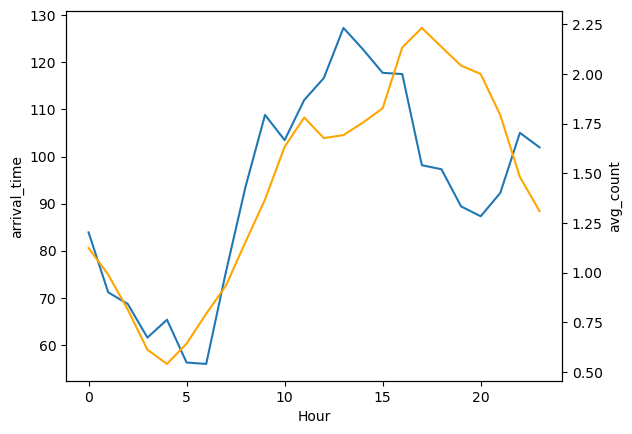

In [57]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
sns.lineplot(avg_at_df, x = "Hour", y = "arrival_time", ax = ax1)
sns.lineplot(avg_at_df, x = "Hour", y = "avg_count", ax = ax2, color = "orange")

In [58]:
avg_at_df.corr()

,Hour,arrival_time,avg_count
Hour,1.000000,0.576590,0.762636
arrival_time,0.576590,1.000000,0.750596
avg_count,0.762636,0.750596,1.000000
